Title of the Analysis
----
Short description of what is being done here. 

Changelog
- make use of scVelo preprocessing without gene filtering. 
- Remove Main Analysis section 1. 
- Add some plots, remove otheres. 
- Use multi-core scVelo to recover dynamics. 

# Preliminaries

## Dependecy notebooks

TODO: define here links to other notebooks which need to be run in the correct order prior
to running this notebook (e.g. data preprocessing/data generation).
If there aren't any, remove this section.

## Import packages

If you want modules to be automatically reloaded when you call them, use `autoreload`:

In [1]:
%load_ext autoreload
%autoreload 2

Import packages

In [2]:
# import standard packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# import single-cell packages
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [3]:
cr.logging.print_versions()

cellrank==1.3.1+ga966e79 scanpy==1.7.2 anndata==0.7.5 numpy==1.19.2 numba==0.51.2 scipy==1.5.3 pandas==1.2.1 pygpcca==1.0.2 scikit-learn==0.24.0 statsmodels==0.12.1 python-igraph==0.8.3 scvelo==0.2.3 pygam==0.8.0 matplotlib==3.3.3 seaborn==0.11.0


In [4]:
cr.logging.print_version_and_date()

Running CellRank 1.3.1+ga966e79, on 2021-05-31 11:25.


## Set up paths

Define the paths to load data, cache results and write figure panels.

In [5]:
sys.path.insert(0, "../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, CACHE_DIR, FIG_DIR

Set up the paths to save figures.

In [6]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Set up caching

Note: we use a caching extension called `scachepy` for this analysis, see [here](https://github.com/theislab/scachepy). We do this to speed up the runtime of this notebook by avoiding the most expensive computations. Below, we check whether you have scachepy installed and if you don't, then we automatically recompute all results. 

In [7]:
try:
    import scachepy
    c = scachepy.Cache(CACHE_DIR / "sample_notebook", separate_dirs=True)
    print('Sucessfully imported scachepy. Expensive computations will be cached. ')
except ImportError:
    print('Failed to import scachepy. Consider installing it from `https://github.com/theislab/scachepy`. ')
    c = None
    
use_caching = c is not None
c

Sucessfully imported scachepy. Expensive computations will be cached. 


Cache(root=/Users/marius/Projects/sc_analysis_template/cache/sample_notebook, ext='.pickle', compression='None')

## Set global parameters

Set some plotting parameters.

In [8]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

Set other global parameters

In [9]:
# should figures just be displayed or also saved?
save_figure = True

# should cashed values be used, or recompute?
force_recompute = False

If there are other global parameters for this analysis, put them here as well. 

## Define utility functions

Any utility functions you may need in this notebook go here. 

## Load the data

Load the AnnData object from the CellRank software package (or from whereever you would like to load your data from)

In [10]:
adata = cr.datasets.pancreas(DATA_DIR / "pancreas" / "pancreas.h5ad")
adata

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

# Quality control and pre-processing

Do your QC and data pre-processing here. 

## Plot annotations

Show spliced/unspliced transcript level abundances, per cluster if annotations available. 

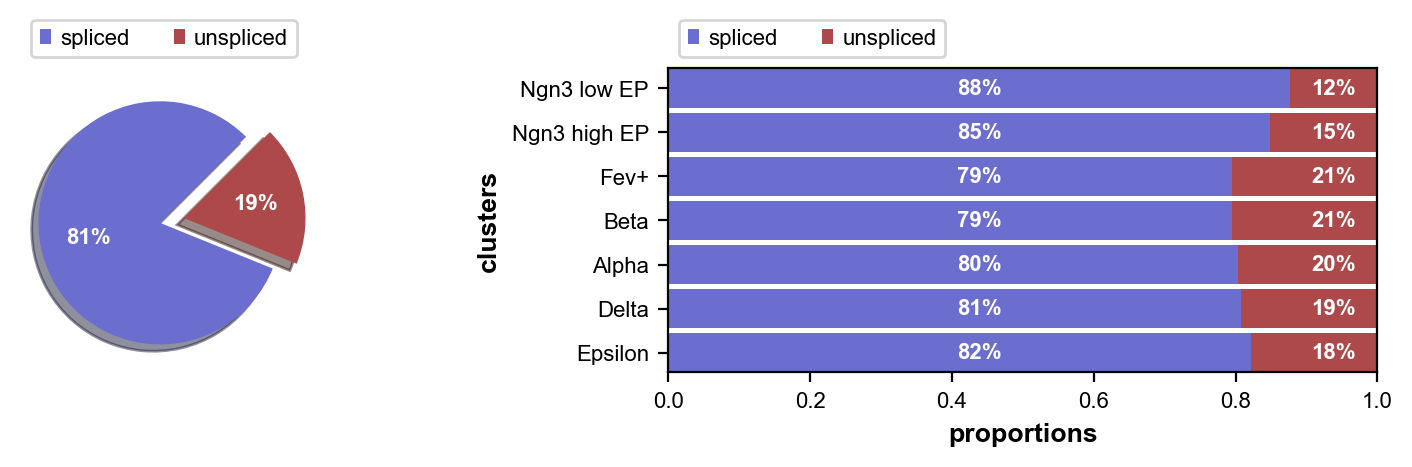

In [11]:
scv.pl.proportions(adata)

Below is an example of optional figure saving, using the global variables defined above. 

saving figure to file /Users/marius/Projects/sc_analysis_template/figures/sample_notebook/pancreas_umap.pdf


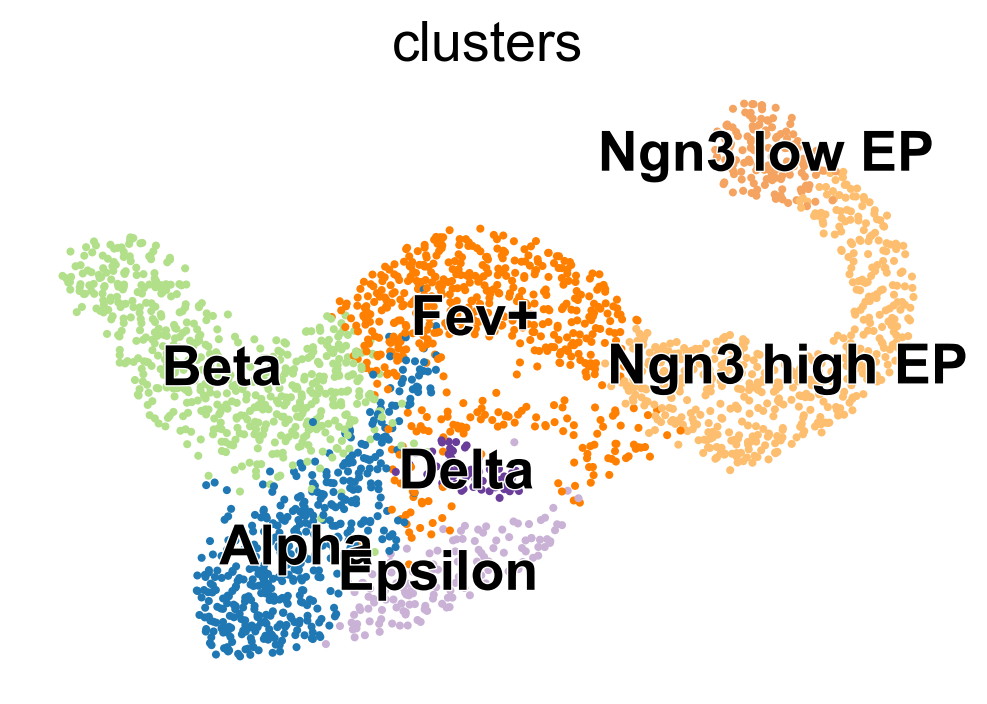

In [12]:
fig_kwargs = {'color': 'clusters', 'dpi': 100}
if save_figure: fig_kwargs['save'] = "sample_notebook/pancreas_umap.pdf"
scv.pl.scatter(adata, **fig_kwargs)

## Pre-process the data

This is standard scVelo preprocessing - genes aren't filtered to hv but only annotated. 

In [13]:
# filter, normalise, log transform
scv.pp.filter_and_normalize(adata, min_shared_counts=20, log=True, n_top_genes=2000, subset_highly_variable=False)

# compute pca, knn graph and scvelo's moments
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.


computing PCA
    on highly variable genes
    with n_comps=50


Extracted 2000 highly variable genes.
Logarithmized X.


    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:02)


computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# scVelo analysis

## Compute velocities using scVelo

In [14]:
# compute/load from cache the dyn. model params and compute velocities
n_jobs = 8

if use_caching:
    c.tl.recover_dynamics(adata, fname='2021-05-31_recover_dynamics', force=force_recompute, n_jobs=n_jobs)
else:
    scv.tl.recover_dynamics(adata, n_jobs=n_jobs)
    
scv.tl.velocity(adata, mode='dynamical')

Loading data from: `2021-05-31_recover_dynamics.pickle`.
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Check top likelihood genes

Look into some phase-portraits to see whether these velocities capture the biological process we're interested in

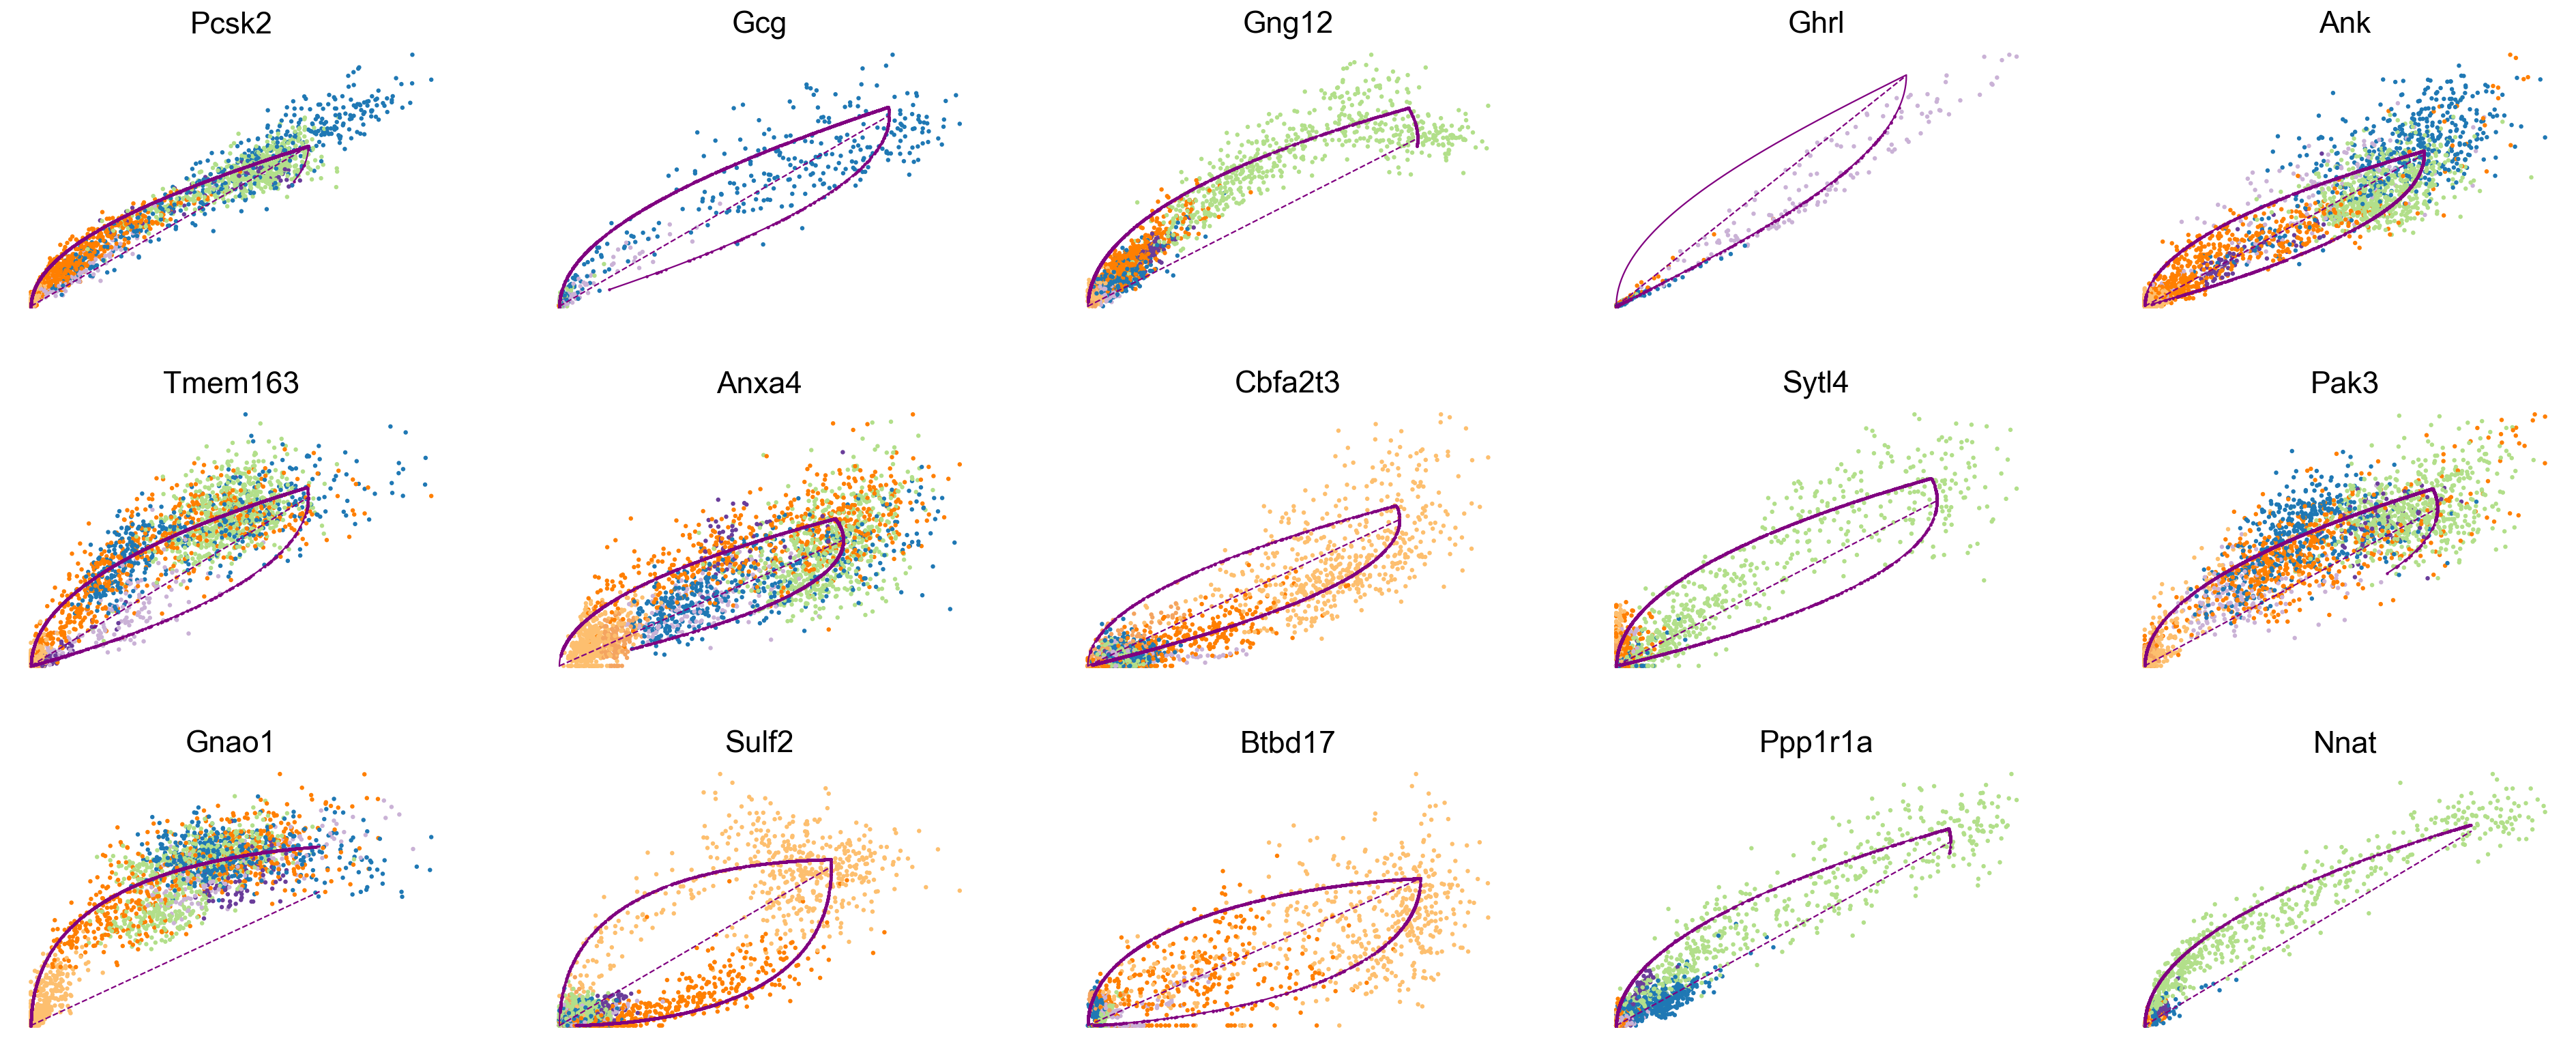

In [15]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, frameon=False)

## Project velocities onto the embedding

Often, we want to show velocities in the UMAP embedding here.

computing velocity graph
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


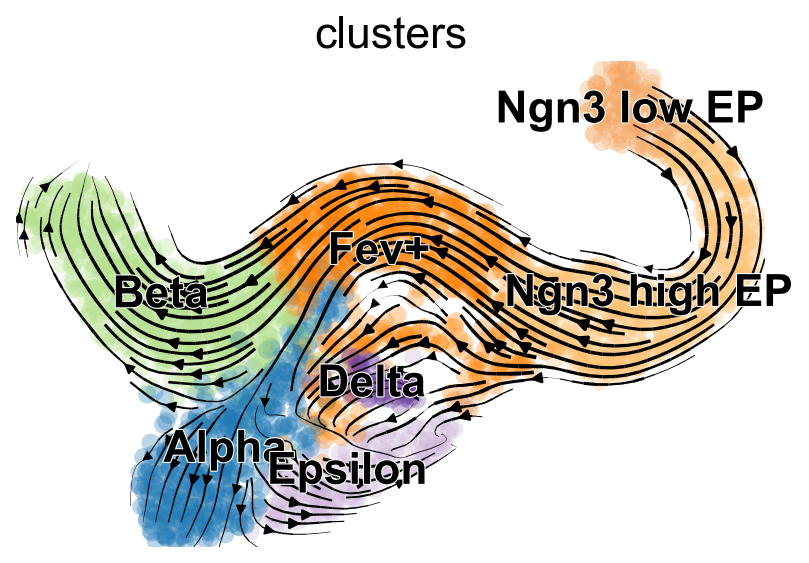

In [16]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata)

# CellRank analysis

Most of the analysis I do usually involve CellRank at some stage. 

## Initialise kernel and estimator

This serves as an example of how to cach a transition matrix and of the default values we should be using. 

In [17]:
from cellrank.tl.estimators import GPCCA

# set the parameters we want to use to compute the transition matrix
weight_connectivities=0.2
mode="stochastic" 
n_jobs=8
softmax_scale=None

if use_caching:
    c.tl.transition_matrix(adata, 
                           weight_connectivities=weight_connectivities, 
                           mode=mode, 
                           n_jobs=n_jobs, 
                           softmax_scale=softmax_scale, 
                           fname='2021-05-31_transition_matrix_stochastic', 
                           force=force_recompute)
    g_fwd = GPCCA(adata, obsp_key='T_fwd')
else:
    kernel = cr.tl.transition_matrix(adata, 
                                     weight_connectivities=weight_connectivities, 
                                     mode=mode, 
                                     n_jobs=n_jobs, 
                                     softmax_scale=softmax_scale)
    g_fwd = GPCCA(kernel)
    
print(g_fwd)

Loading data from: `2021-05-31_transition_matrix_stochastic.pickle`.
GPCCA[n=2531, kernel=<PrecomputedKernel[origin='array']>]


## Print transition matrix statistics for reproducibility

To make sure that we're using the same transition matrix, show some stats. 

In [18]:
# just for consistency, display some summary staes about the transition matrix
T = adata.obsp['T_fwd']
T_med, T_mean, T_var = np.median(T.data), np.mean(T.data), np.var(T.data)
T_min, T_max = np.min(T.data), np.max(T.data)

print(f'med = {T_med:.6f},\nmean = {T_mean:.6f},\nvar = {T_var:.6f},\nmin = {T_min:.6f},\nmax = {T_max:.6f}')

med = 0.018748,
mean = 0.024591,
var = 0.000466,
min = 0.000058,
max = 0.426351


## Compute the real Schur decomposition

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[5, 9]`
Adding `adata.uns['eig_fwd']`
       `.eigendecomposition`
       `.schur`
       `.schur_matrix`
    Finish (0:00:00)


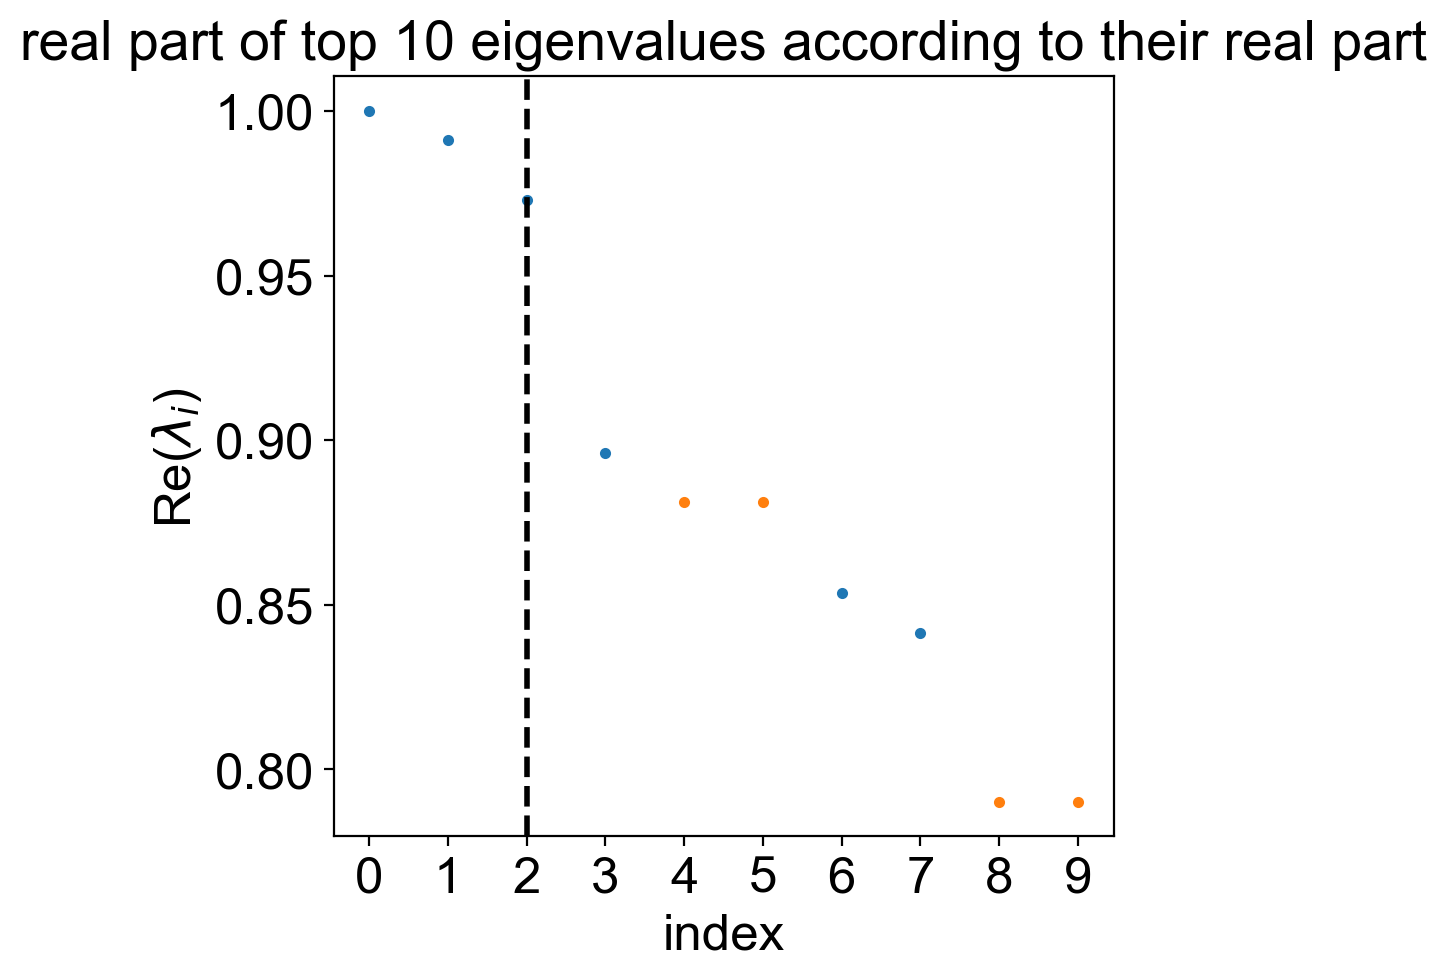

In [19]:
g_fwd.compute_schur()
g_fwd.plot_spectrum(real_only=True)